## Inference Analysis

In this notebook we're looking at the statistical significance of distribution differences between weather features and the extent of traffic delay severity caused by an accident.  The original data had four rankings of severity, which will be reduced to two, 0 = low and 1 = high.

In [1]:
import pandas as pd

# Import Data
train = pd.read_csv('C:/data/Accidents.csv')

# Reduce traffic Severity from four categories down to two
train['SeverityLoHi'] = train['Severity'].apply(lambda x: 1 if x >= 3 else 0)

high = train.loc[train.SeverityLoHi == 1,:].copy()
low = train.loc[train.SeverityLoHi == 0,:].copy()


In [13]:
# Correlation of Weather Metrics
cols = ['SeverityLoHi', 'Duration(m)', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
train[cols].corr().round(3)

,SeverityLoHi,Duration(m),Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
SeverityLoHi,1.000,-0.034,0.117,-0.016,-0.021,0.018,0.039,-0.015,0.029,0.026
Duration(m),-0.034,1.000,0.260,0.004,-0.017,-0.029,0.018,0.016,0.038,0.031
Distance(mi),0.117,0.260,1.000,-0.054,-0.051,0.019,0.007,-0.011,0.030,0.022
Temperature(F),-0.016,0.004,-0.054,1.000,0.834,-0.326,-0.207,0.212,0.004,0.057
Wind_Chill(F),-0.021,-0.017,-0.051,0.834,1.000,-0.139,-0.273,0.155,-0.111,0.039
Humidity(%),0.018,-0.029,0.019,-0.326,-0.139,1.000,0.034,-0.411,-0.156,0.105
Pressure(in),0.039,0.018,0.007,-0.207,-0.273,0.034,1.000,0.036,-0.010,0.056
Visibility(mi),-0.015,0.016,-0.011,0.212,0.155,-0.411,0.036,1.000,0.028,-0.124
Wind_Speed(mph),0.029,0.038,0.030,0.004,-0.111,-0.156,-0.010,0.028,1.000,0.035
Precipitation(in),0.026,0.031,0.022,0.057,0.039,0.105,0.056,-0.124,0.035,1.000


Initially, it is disappointing to see little-to-no correlation between Accident Traffic Severity and weather conditions.  A minor correlation between Severity and Distance in miles is present.

Between the weather conditions, distance and duration:
There is only one observed strong correlation between Temperature and Wind Chill.

A moderate, negative correlation between Visibility and Humidity, as increased humidity can create foggy driving conditions. Interestingly, Temperature and Humidity are also negatively correlated. According to online sources, as air temperature increases, air can hold more water vapor, and its relative humidity decreases.

Duration and Distance of traffic have a low correlation together of 0.26. Surprisingly, Temperature alone, which could indicate freezing conditions, does not correlate to Duration or Distance of traffic accidents. There are no weather metrics with clear correlation to accident severity, duration, or distance.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Seed Random
np.random.seed(7)

# Set default for figure sizes
mpl.rcParams['figure.figsize'] = (16,6)

# Define common statistical support functions

# Comparison Function Difference of Means
def mean_diff(data1,data2):
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    return mean1 - mean2

# Permutation Sample Function
def permutation_sample(data1,data2):
    """
    Creates a Permutation Sample from two data sets and returns two permutated samples 
    with the same length as the original sets.
    """
    data_both = np.concatenate((data1,data2))
    data_perm = np.random.permutation(data_both)
    perm_sample_1 = data_perm[:len(data1)]
    perm_sample_2 = data_perm[len(data1):]
    return (perm_sample_1,perm_sample_2)

# Generate Permutation Replicates
def draw_perm_reps(data1,data2,func,size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1,perm_sample_2 = permutation_sample(data1,data2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

# Empirical Cumulative Distribution Function
def ecdf(data):
    """
    Returns the x,y values for data for plotting as an ecdf.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    
    return x,y

# p-values, confidence intervals, margin of error
def test_mean_diff(data1,data2,mean_diff_val,h0_diff=0):
    perm_replicates = draw_perm_reps(data1,data2,mean_diff,100)

    if mean_diff_val > 0:
        p = np.sum(perm_replicates >= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))
    else:
        p = np.sum(perm_replicates <= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))

    CI = np.percentile(perm_replicates,[2.5,97.5])
    print("CI: {}".format(CI))

    ME = CI[1] - np.mean(perm_replicates)
    print("ME: {}".format(ME))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

    plt.subplot(1,2,1)

    dist_ax = sns.distplot(perm_replicates,bins=25,color='gray')
    max_dist_y = np.array([h.get_height() for h in dist_ax.patches]).max()
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Density')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.legend(['Mean Difference Distribution \nfor p(high)=p(low)'],loc='upper left')
    _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,max_dist_y*0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

    plt.subplot(1,2,2)

    x,y = ecdf(perm_replicates)
    y_interp = np.interp(x,x,y)
    _ = plt.plot(x,y_interp,color='gray')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Cumulative Probability')
    _ = plt.legend(['Mean Difference Distribution \nfor p(high)=p(low)'],loc='lower right')
    if mean_diff_val >= 0:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,1),xytext=(mean_diff_val,0.8),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})
    else:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

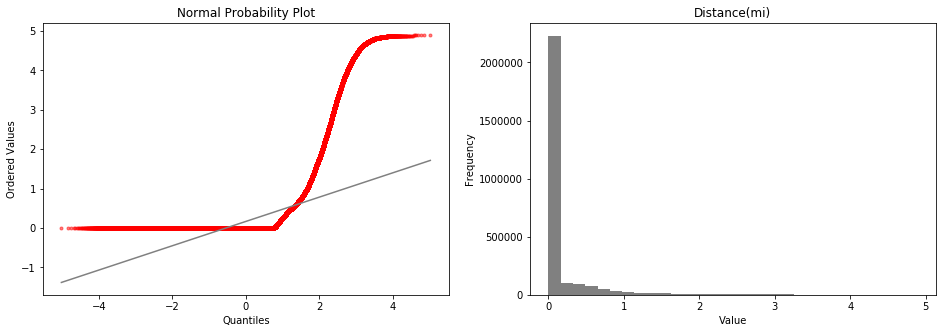

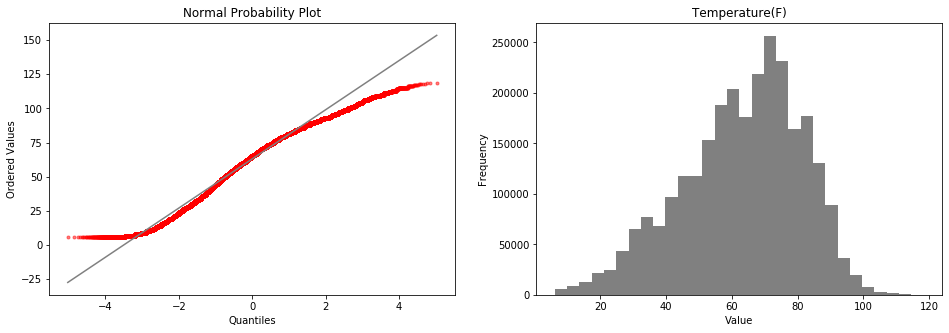

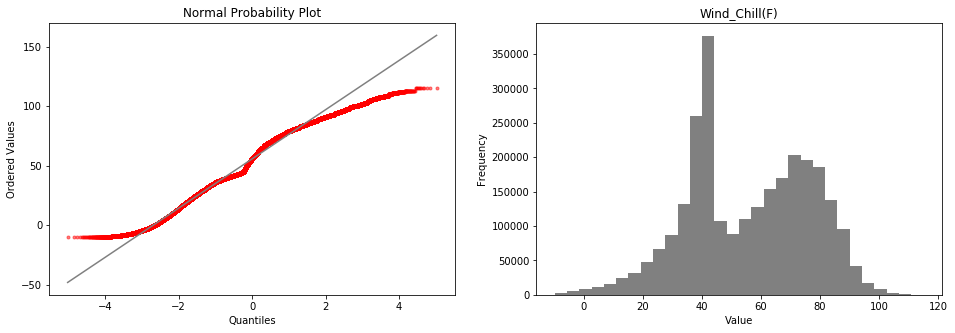

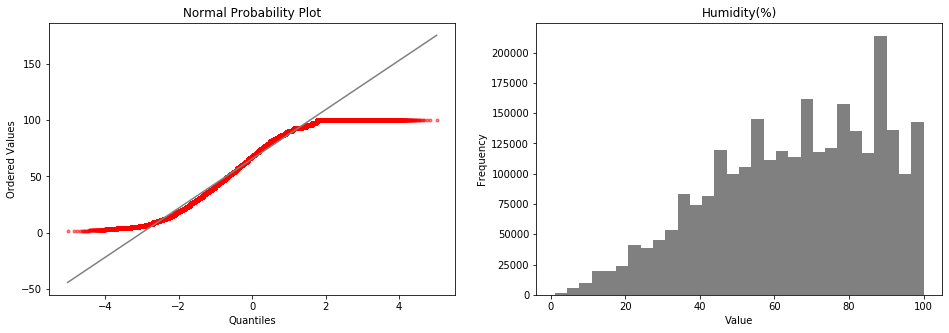

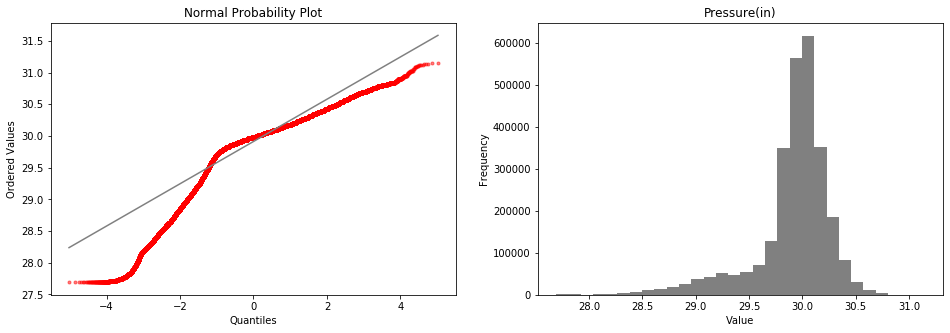

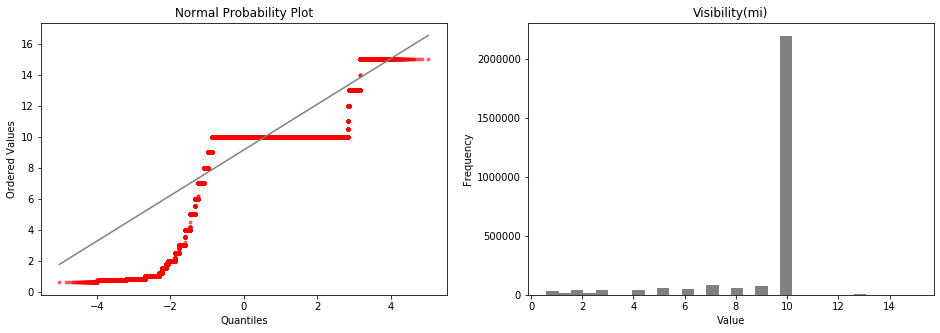

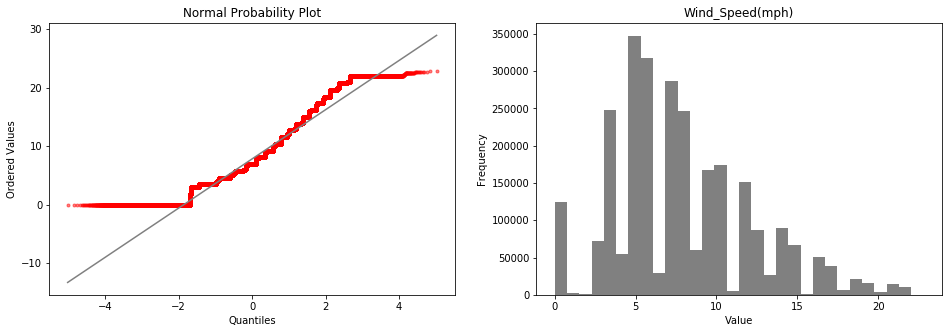

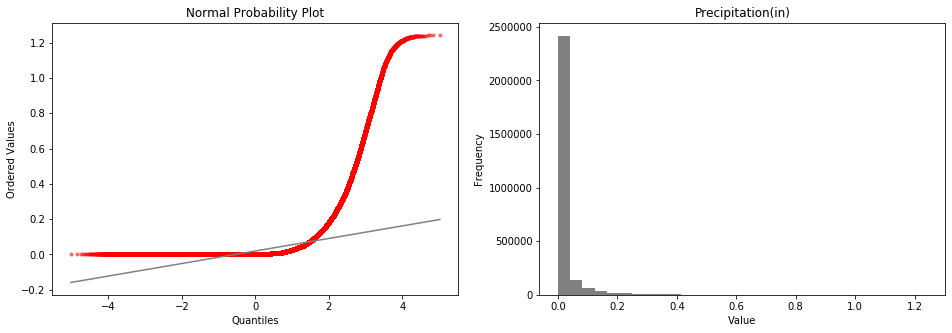

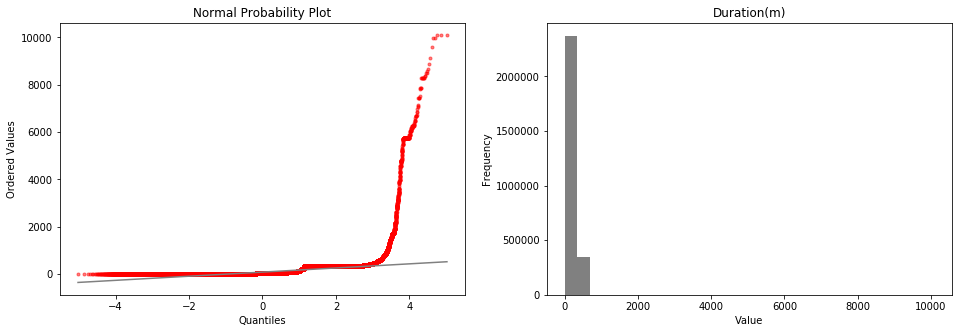

In [4]:
# QQ plot per feature
import scipy.stats as stats

def lreg_line(slope,intercept,test_data):
    x_lreg = np.array([min(test_data),max(test_data)])
    y_lreg = slope * x_lreg + intercept
    return x_lreg,y_lreg
        
def qq_plot(data):
    data_no_na = data.dropna()
    fig, ax = plt.subplots(1,2,figsize=(16, 5))
    _ = plt.subplot(1,2,1)
    (x,y), (slope,intercept,r) = stats.probplot(data_no_na, dist="norm", plot=None)
    _ = plt.plot(x,y,marker='.',linestyle='none',color='red',alpha=0.5)
    x_lreg,y_lreg = lreg_line(slope,intercept,x)
    _ = plt.plot(x_lreg,y_lreg,color='gray')
    _ = plt.xlabel('Quantiles')
    _ = plt.ylabel('Ordered Values')
    _ = plt.title('Normal Probability Plot')
    _ = plt.subplot(1,2,2)
    _ = plt.hist(data_no_na, color='gray',bins=30)
    _ = plt.xlabel('Value')
    _ = plt.ylabel('Frequency')

features = ['Distance(mi)','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Duration(m)']

for feature in features:
    qq_plot(train[feature])
    plt.title(feature)

Unfortunately, we are not dealing with normal distributions in this case. We will see that normality is achieved by using the mean difference with permutations in the following plots.

## Compare Means of High Accident Traffic Severity vs. Low Across Weather Metrics

The following box plots look similar to the eye, but with a p-value at zero, the null hypotheses that means are the same between high severity and low severity traffic accident delays must be rejected.  The differences are statistically significant.

## Temperature Distribution (Fahrenheit)
To better understand whether the distributions are statistically significantly different we will use a Z-Test.

    H0: The Temperature(F) Distribution for High and Low Accident Traffic Severity is the same (i.e. the mean diff is 0).   
    H1: The Temperature(F) Distribution for High and Low Accident Traffic Severity is not the same.
    alpha = 0.05

High Severity Temp Mean: 62.631576185300524
Low Severity Temp Mean: 63.253038855079296
Mean Diff: -0.6214626697787722
H0 Diff: 0


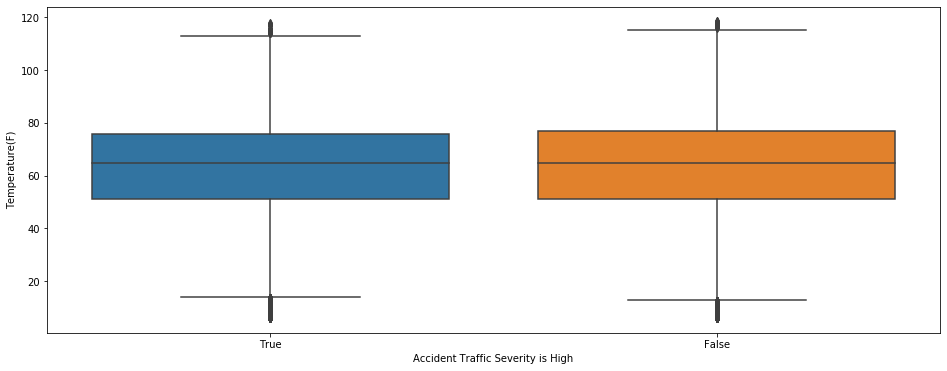

p: 0.0
CI: [-0.04549529  0.04557832]
ME: 0.045342842486068374


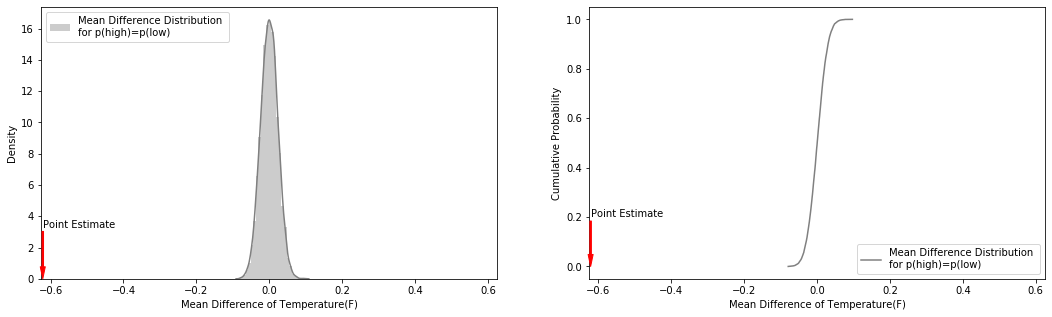

In [17]:
high_temperature = high['Temperature(F)'].dropna()
low_temperature = low['Temperature(F)'].dropna()

high_low_diff = high_temperature.mean() - low_temperature.mean()
h0_diff = 0
print("High Severity Temp Mean: {}\nLow Severity Temp Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_temperature.mean(), low_temperature.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi',y='Temperature(F)',data=train,order=[True,False])
plt.xlabel('Accident Traffic Severity is High')
plt.show()

test_mean_diff(high_temperature,low_temperature,high_low_diff)

## Wind Chill Distribution (F)

High Severity Wind Chill Mean: 55.097404331308965
Low Severity Wind Chill Mean: 56.03127442936648
Mean Diff: -0.9338700980575183
H0 Diff: 0


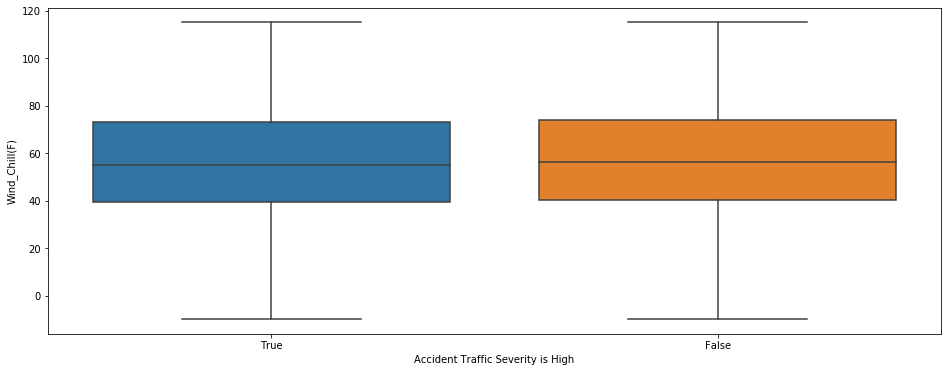

p: 0.0
CI: [-0.05253402  0.05420689]
ME: 0.056203771489226576


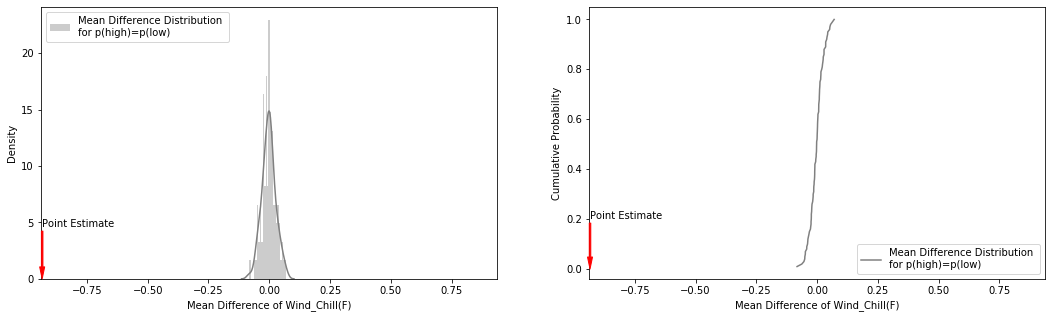

In [4]:
high_wind_chill = high['Wind_Chill(F)'].dropna()
low_wind_chill = low['Wind_Chill(F)'].dropna()

high_low_diff = high_wind_chill.mean() - low_wind_chill.mean()
h0_diff = 0
print("High Severity Wind Chill Mean: {}\nLow Severity Wind Chill Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_wind_chill.mean(), low_wind_chill.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi',y='Wind_Chill(F)',data=train,order=[True,False])
plt.xlabel('Accident Traffic Severity is High')
plt.show()

test_mean_diff(high_wind_chill,low_wind_chill,high_low_diff)

## Precipitation Distribution (inches)

High Severity Precip Mean: 0.021489413548949943
Low Severity Precip Mean: 0.01808836437391758
Mean Diff: 0.0034010491750323633
H0 Diff: 0


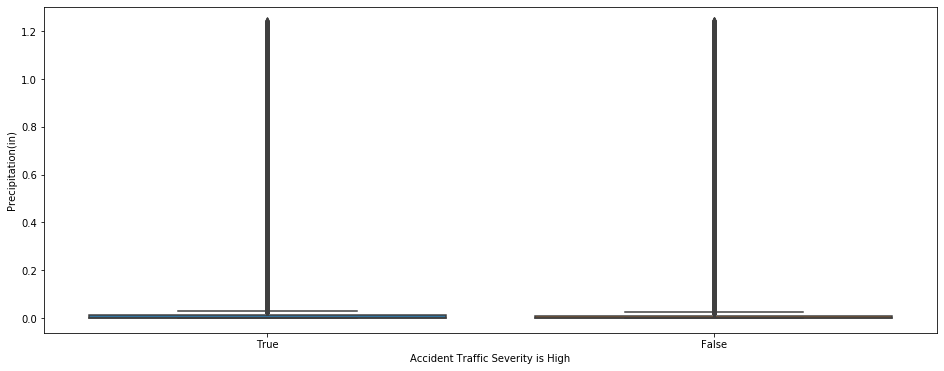

p: 0.0
CI: [-0.00015773  0.00012736]
ME: 0.00014108419091872005


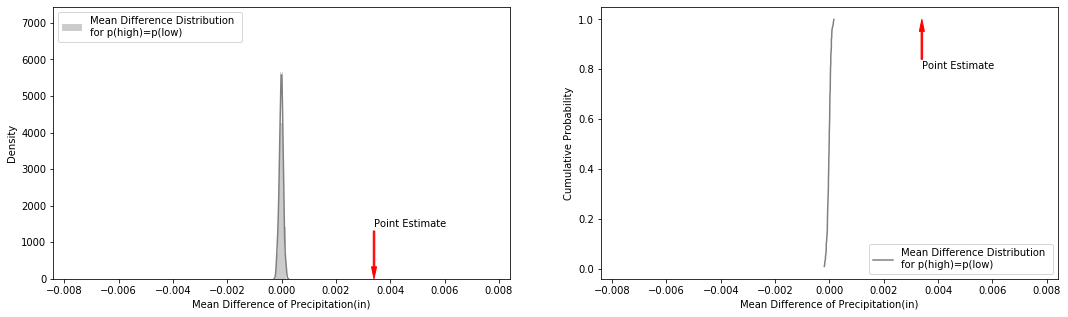

In [5]:
high_precipitation = high['Precipitation(in)'].dropna()
low_precipitation = low['Precipitation(in)'].dropna()

high_low_diff = high_precipitation.mean() - low_precipitation.mean()
h0_diff = 0
print("High Severity Precip Mean: {}\nLow Severity Precip Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_precipitation.mean(), low_precipitation.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi',y='Precipitation(in)',data=train,order=[True,False])
plt.xlabel('Accident Traffic Severity is High')
plt.show()

test_mean_diff(high_precipitation,low_precipitation,high_low_diff)

## Pressure Distribution (in)

High Severity Pressure Mean: 29.932684963998195
Low Severity Pressure Mean: 29.90275656117535
Mean Diff: 0.02992840282284348
H0 Diff: 0


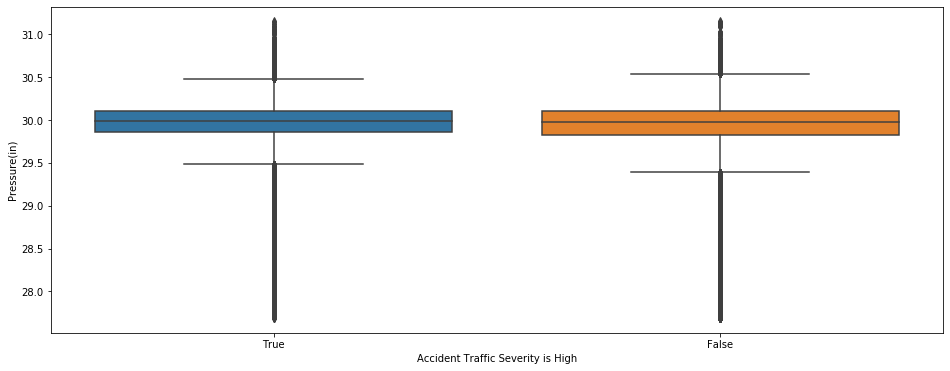

p: 0.0
CI: [-0.00091282  0.0009292 ]
ME: 0.0009489325681251153


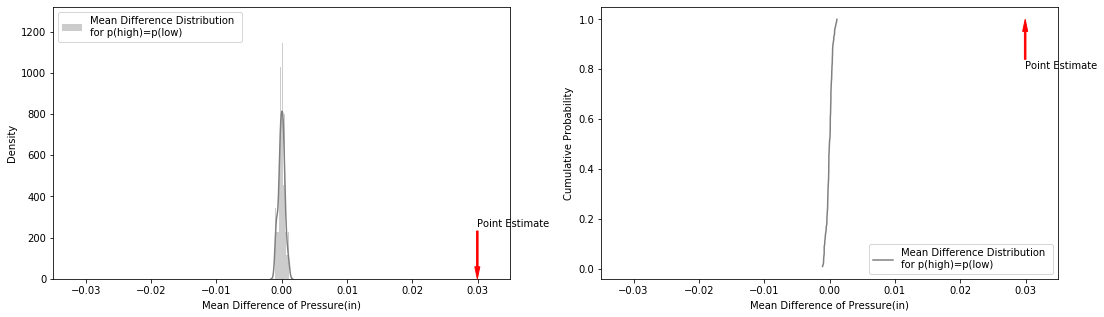

In [6]:
high_pressure = high['Pressure(in)'].dropna()
low_pressure = low['Pressure(in)'].dropna()

high_low_diff = high_pressure.mean() - low_pressure.mean()
h0_diff = 0
print("High Severity Pressure Mean: {}\nLow Severity Pressure Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_pressure.mean(), low_pressure.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi',y='Pressure(in)',data=train,order=[True,False])
plt.xlabel('Accident Traffic Severity is High')
plt.show()

test_mean_diff(high_pressure,low_pressure,high_low_diff)

## Distance Distribution (of traffic in miles)

High Severity Distance Mean: 0.2512084166855638
Low Severity Distance Mean: 0.12522722810616832
Mean Diff: 0.1259811885793955
H0 Diff: 0


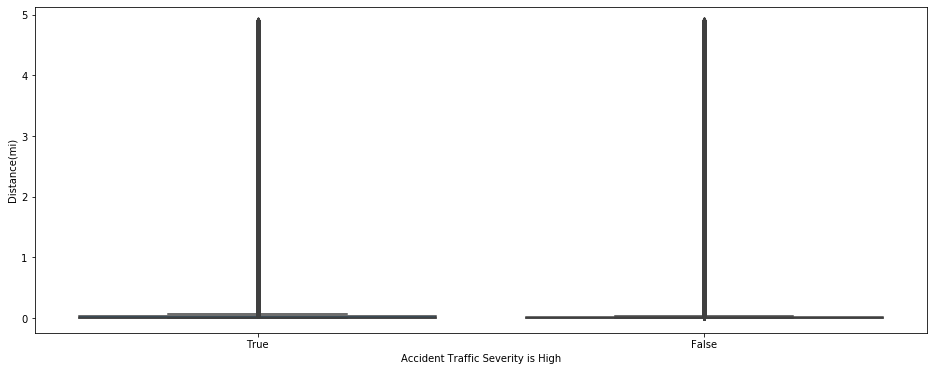

p: 0.0
CI: [-0.00119538  0.00151461]
ME: 0.0014883721547836104


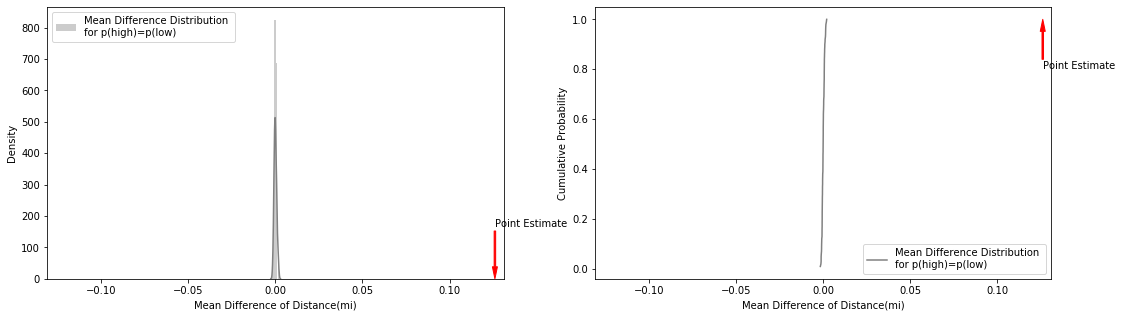

In [7]:
high_distance = high['Distance(mi)'].dropna()
low_distance = low['Distance(mi)'].dropna()

high_low_diff = high_distance.mean() - low_distance.mean()
h0_diff = 0
print("High Severity Distance Mean: {}\nLow Severity Distance Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_distance.mean(), low_distance.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi',y='Distance(mi)',data=train,order=[True,False])
plt.xlabel('Accident Traffic Severity is High')
plt.show()

test_mean_diff(high_distance,low_distance,high_low_diff)

## Visibility Distribution (mi)

High Severity Visibility Mean: 9.099958550434941
Low Severity Visibility Mean: 9.169369398990689
Mean Diff: -0.06941084855574786
H0 Diff: 0


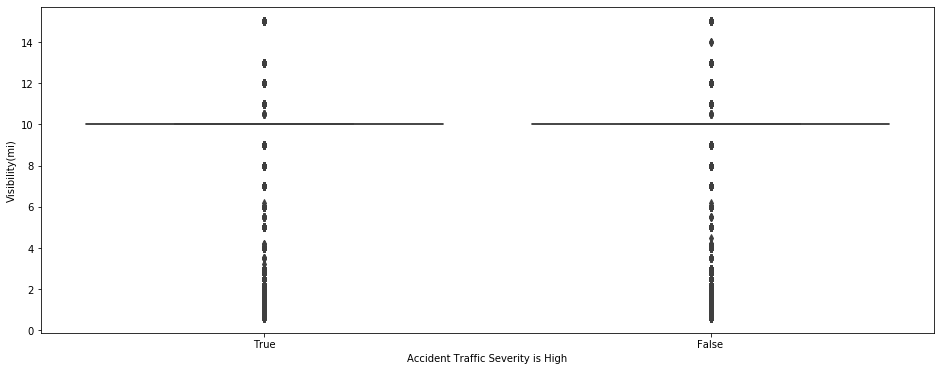

p: 0.0
CI: [-0.00488375  0.00528134]
ME: 0.0049920417356925095


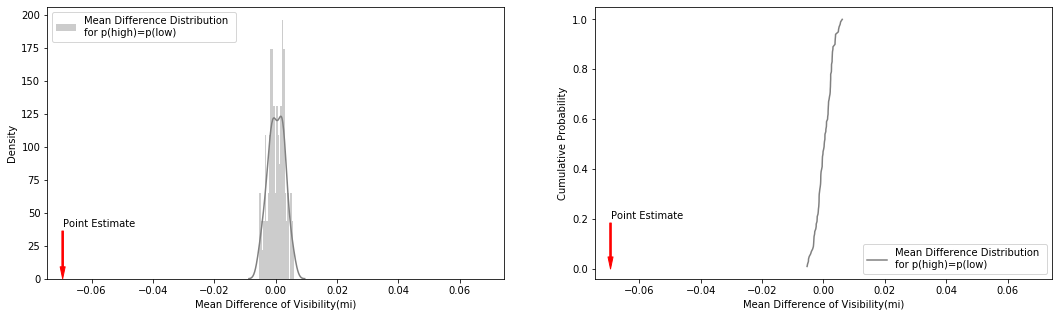

In [8]:
high_visibility = high['Visibility(mi)'].dropna()
low_visibility = low['Visibility(mi)'].dropna()

high_low_diff = high_visibility.mean() - low_visibility.mean()
h0_diff = 0
print("High Severity Visibility Mean: {}\nLow Severity Visibility Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_visibility.mean(), low_visibility.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi',y='Visibility(mi)',data=train,order=[True,False])
plt.xlabel('Accident Traffic Severity is High')
plt.show()

test_mean_diff(high_visibility,low_visibility,high_low_diff)

## Wind Speed Distribution (mph)

High Severity Wind Speed Mean: 7.999216873394668
Low Severity Wind Speed Mean: 7.7370550303059735
Mean Diff: 0.2621618430886947
H0 Diff: 0


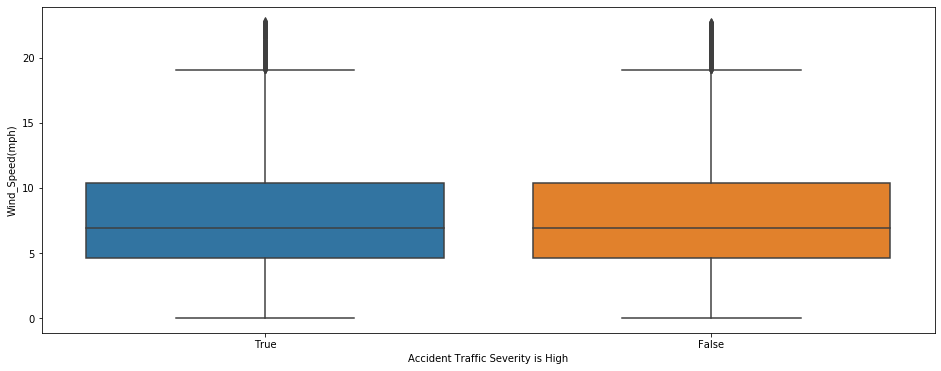

p: 0.0
CI: [-0.00960384  0.00912603]
ME: 0.008535705365090723


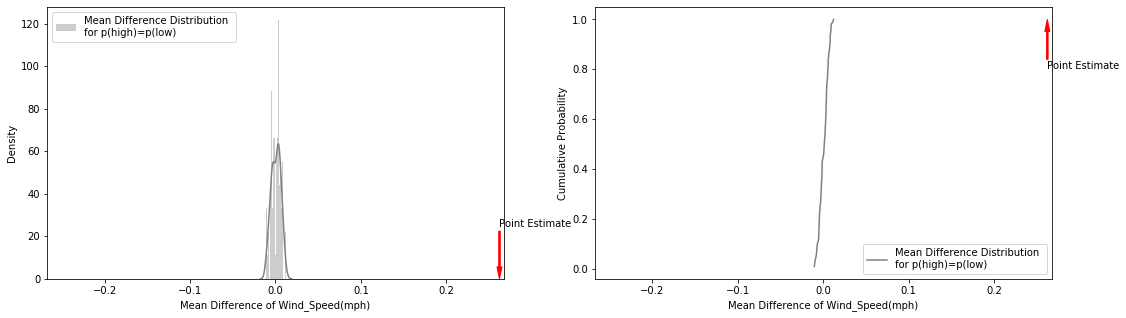

In [9]:
high_wind_speed = high['Wind_Speed(mph)'].dropna()
low_wind_speed = low['Wind_Speed(mph)'].dropna()

high_low_diff = high_wind_speed.mean() - low_wind_speed.mean()
h0_diff = 0
print("High Severity Wind Speed Mean: {}\nLow Severity Wind Speed Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_wind_speed.mean(), low_wind_speed.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi',y='Wind_Speed(mph)',data=train,order=[True,False])
plt.xlabel('Accident Traffic Severity is High')
plt.show()

test_mean_diff(high_wind_speed,low_wind_speed,high_low_diff)

## Humidity Distribution (%)

High Severity Humidity Mean: 66.08772904320682
Low Severity Humidity Mean: 65.21196348289683
Mean Diff: 0.8757655603099863
H0 Diff: 0


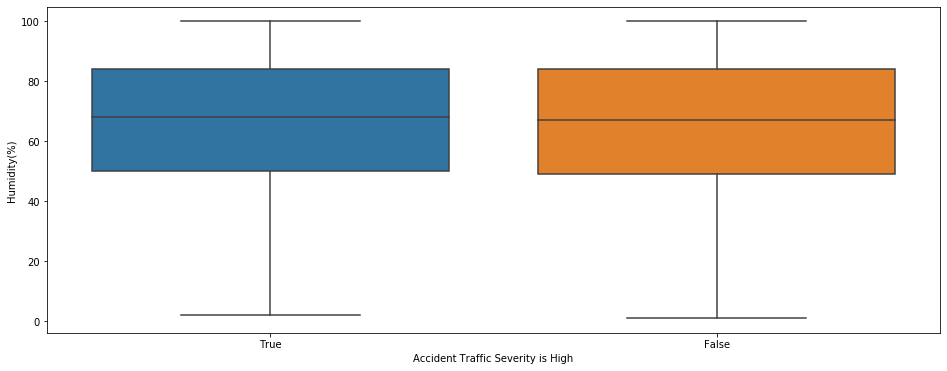

p: 0.0
CI: [-0.04961617  0.05213289]
ME: 0.051354844164113504


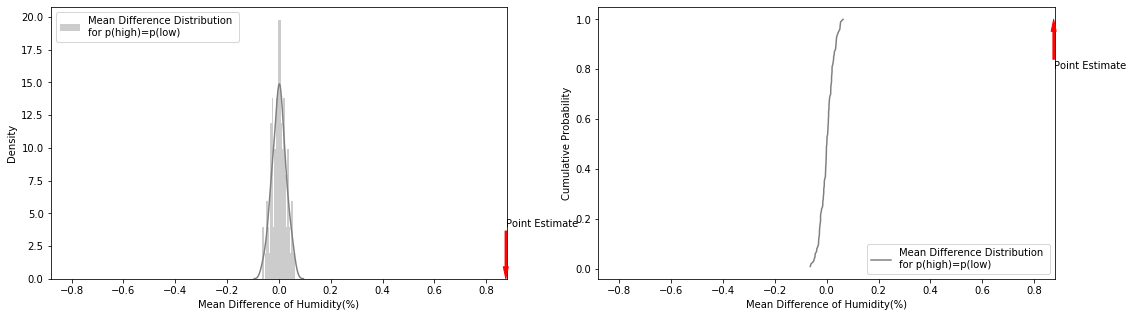

In [10]:
high_humidity = high['Humidity(%)'].dropna()
low_humidity = low['Humidity(%)'].dropna()

high_low_diff = high_humidity.mean() - low_humidity.mean()
h0_diff = 0
print("High Severity Humidity Mean: {}\nLow Severity Humidity Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_humidity.mean(), low_humidity.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi',y='Humidity(%)',data=train,order=[True,False])
plt.xlabel('Accident Traffic Severity is High')
plt.show()

test_mean_diff(high_humidity,low_humidity,high_low_diff)